In [318]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import lightgbm as lgb
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
import holidays
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
import optuna

In [2]:
os.chdir('..')

In [74]:
sample_submission = pd.read_csv('./data/sample_submission.csv')
test = pd.read_csv('./data/test.csv')
train = pd.read_csv('./data/train.csv')

In [75]:
train = train.assign(date=lambda df_ : pd.to_datetime(df_.date))
test = test.assign(date=lambda df_ : pd.to_datetime(df_.date))

# Preprocessing

In [131]:
data = train.append(test)

In [132]:
data = data.assign(day_month = lambda df_ : df_.date.dt.day
            ,month = lambda df_ : df_.date.dt.month
            ,year = lambda df_ : df_.date.dt.year
            ,day_week = lambda df_ : df_.date.dt.dayofweek
            ,day_year = lambda df_ : df_.date.dt.dayofyear)

In [133]:
data.head()

,row_id,date,country,store,product,num_sold,day_month,month,year,day_week,day_year
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663.0,1,1,2017,6,1
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615.0,1,1,2017,6,1
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480.0,1,1,2017,6,1
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710.0,1,1,2017,6,1
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240.0,1,1,2017,6,1


In [134]:
enc = OrdinalEncoder()
enc.fit(data[["country","store", "product"]])

OrdinalEncoder()

In [135]:
data[["country","store", "product"]] = enc.transform(data[["country", "store", "product"]])

In [136]:
holidays_mapping = {0.0 : 'BE', 1.0 : 'FR', 2.0 : 'DE', 3.0 : 'IT', 4.0 : 'PL', 5.0 : 'ES'}

In [137]:
data['iso_country'] = data.country.map(holidays_mapping)

In [138]:
data['is_holiday'] = data.apply(lambda x: int(x.date in holidays.country_holidays(x['iso_country'])), axis=1)

In [139]:
data2 = data.copy()

In [366]:
data = data2.copy()

In [367]:
SHIFT_DAY = 365

In [368]:
LAG_DAYS = [col for col in range(SHIFT_DAY,SHIFT_DAY+10)]
data = data.assign(**{
        '{}_lag_{}'.format(col, l): data.groupby(["country",'store','product'])[col].transform(lambda x: x.shift(l))
        for l in LAG_DAYS
        for col in ['num_sold']
    })

In [369]:
print('Create rolling aggs')

for i in [7,14,30,60]:
    print('Rolling period:', i)
    data['rolling_mean_'+str(i)] = data.groupby(["country",'store','product'])['num_sold'].transform(lambda x: x.shift(SHIFT_DAY).rolling(i).mean()).astype(np.float16)
    data['rolling_std_'+str(i)]  = data.groupby(["country",'store','product'])['num_sold'].transform(lambda x: x.shift(SHIFT_DAY).rolling(i).std()).astype(np.float16)

Create rolling aggs
Rolling period: 7
Rolling period: 14
Rolling period: 30
Rolling period: 60


# Model

In [370]:
final_data = data.drop(columns=['row_id','date','day_month', 'iso_country','month'])

In [371]:
final_data.columns

Index(['country', 'store', 'product', 'num_sold', 'year', 'day_week',
       'day_year', 'is_holiday', 'num_sold_lag_365', 'num_sold_lag_366',
       'num_sold_lag_367', 'num_sold_lag_368', 'num_sold_lag_369',
       'num_sold_lag_370', 'num_sold_lag_371', 'num_sold_lag_372',
       'num_sold_lag_373', 'num_sold_lag_374', 'rolling_mean_7',
       'rolling_std_7', 'rolling_mean_14', 'rolling_std_14', 'rolling_mean_30',
       'rolling_std_30', 'rolling_mean_60', 'rolling_std_60'],
      dtype='object')

In [372]:
final_test = final_data[final_data.num_sold.isna()]
pre_train = final_data[~final_data.num_sold.isna()]
final_eval = pre_train[pre_train.year == 2020]
final_train = pre_train[~(pre_train.year == 2020)]

In [373]:
y_train = final_train.num_sold
y_eval = final_eval.num_sold
X_eval = final_eval.drop(columns='num_sold')
X_train = final_train.drop(columns='num_sold')
X_test = final_test.drop(columns='num_sold')

In [374]:
y_train_final = pre_train.num_sold
X_train_final = pre_train.drop(columns='num_sold')

In [375]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_eval, y_eval, reference=lgb_train)
lgb_train_final = lgb.Dataset(X_train_final, y_train_final)

In [376]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'mse',
    'metric': ['rmse', 'mape'],
    'n_estimators':300,
#     'num_leaves': 31,
    'learning_rate': 0.03,
#      'feature_fraction': 0.8,
#      'bagging_fraction': 0.8,
#      'bagging_freq': 1,
    'verbose': -1
}

In [377]:
gbm = lgb.train(params,
                lgb_train,
                valid_sets=[lgb_train,lgb_eval],
                verbose_eval=50,
                early_stopping_rounds=50)

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 38.1599	training's mape: 0.256201	valid_1's rmse: 80.64	valid_1's mape: 0.23927
[100]	training's rmse: 21.435	training's mape: 0.116074	valid_1's rmse: 80.2539	valid_1's mape: 0.227886
Early stopping, best iteration is:
[69]	training's rmse: 28.64	training's mape: 0.177612	valid_1's rmse: 79.5018	valid_1's mape: 0.225807


In [378]:
# [84]	training's rmse: 25.1476	training's mape: 0.146172	valid_1's rmse: 74.3659	valid_1's mape: 0.214204

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

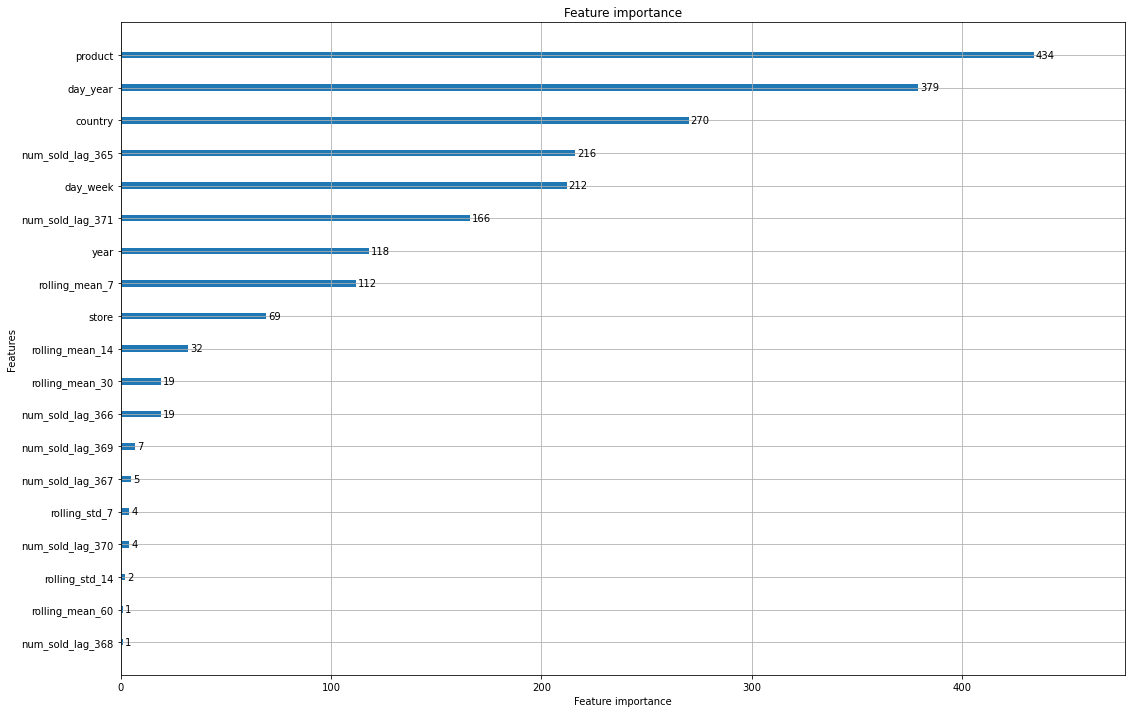

In [379]:
lgb.plot_importance(gbm,figsize=(18,12))

In [380]:
predictions = gbm.predict(X_eval)

In [381]:
X_eval_2 = X_eval.copy()
X_eval_2['predictions'] = predictions
X_eval_2['date'] = data[data.year==2020].date
X_eval_2['num_sold'] = y_eval

In [382]:
muestra = X_eval_2[(X_eval_2['product']==0) & (X_eval_2.store==0) & (X_eval_2.country==0)]

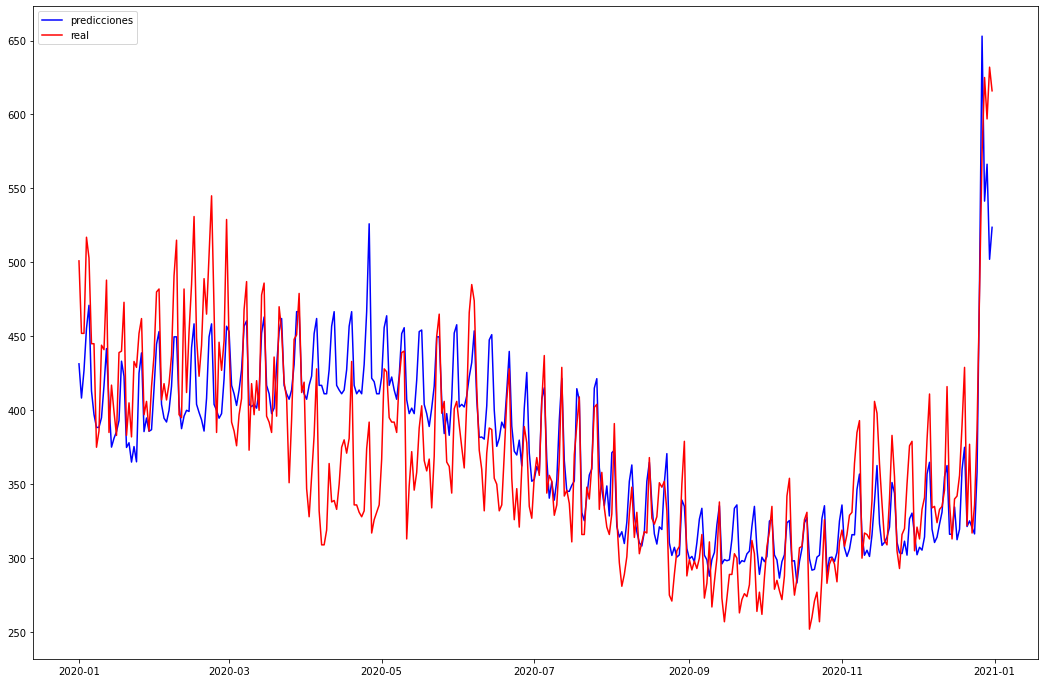

In [383]:
plt.figure(figsize=(18,12))
plt.plot(muestra.date, muestra.predictions, color='blue', label='predicciones')
plt.plot(muestra.date, muestra.num_sold, color='red', label='real')
plt.legend()
plt.show()

# Optuna Trial

In [384]:
def objective(trial):
#     data, target = sklearn.datasets.load_breast_cancer(return_X_y=True)
#     train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25)
#     dtrain = lgb.Dataset(train_x, label=train_y)

    final_param = {
        "objective": trial.suggest_categorical('objective', ['mse', 'mae', 'mape']),
        "metric": "mse",
        "verbosity": -1,
        "boosting_type": "gbdt",
        'n_estimators' : trial.suggest_int("n_estimators", 50, 500),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True)
#         "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.train(final_param, lgb_train)
    preds = gbm.predict(X_eval)
#     pred_labels = np.rint(preds)
#     accuracy = mean_absolute_percentage_error(y_eval, preds)
    accuracy = mean_squared_error(y_eval, preds)
    return accuracy

In [320]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=500)

[I 2022-09-22 19:08:21,139] A new study created in memory with name: no-name-b74e5322-1c5d-44cd-8006-43fb2782b896
[I 2022-09-22 19:08:22,860] Trial 0 finished with value: 7062.918857946398 and parameters: {'objective': 'mape', 'n_estimators': 289, 'lambda_l1': 3.261104633452691e-07, 'lambda_l2': 1.2017214803038146e-07, 'num_leaves': 66, 'feature_fraction': 0.5638021321998008, 'bagging_fraction': 0.7023766457392164, 'bagging_freq': 7, 'learning_rate': 0.01585858017879863}. Best is trial 0 with value: 7062.918857946398.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:08:23,918] Trial 1 finished with value: 6948.275093309409 and parameters: {'objective': 'mape', 'n_estimators': 116, 'lambda_l1': 1.9995052602469524e-05, 'lambda_l2': 1.6577130113087515e-06, 'num_leaves': 108, 'feature_fraction': 0.882

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:08:52,274] Trial 13 finished with value: 6046.091407711687 and parameters: {'objective': 'mse', 'n_estimators': 376, 'lambda_l1': 0.0007313359847514055, 'lambda_l2': 4.792533732980989, 'num_leaves': 177, 'feature_fraction': 0.6367530356178079, 'bagging_fraction': 0.5051176291719406, 'bagging_freq': 1, 'learning_rate': 0.00586940287644345}. Best is trial 10 with value: 5928.446172957349.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:08:55,720] Trial 14 finished with value: 6026.889106099852 and parameters: {'objective': 'mse', 'n_estimators': 481, 'lambda_l1'

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:09:36,207] Trial 26 finished with value: 6360.187603153402 and parameters: {'objective': 'mse', 'n_estimators': 407, 'lambda_l1': 0.0001634669070887316, 'lambda_l2': 7.886230597986389e-08, 'num_leaves': 135, 'feature_fraction': 0.674333258265909, 'bagging_fraction': 0.5600745304410882, 'bagging_freq': 1, 'learning_rate': 0.018939288251534545}. Best is trial 10 with value: 5928.446172957349.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:09:38,089] Trial 27 finished with value: 9497.184536660758 and parameters: {'objective': 'mape', 'n_estimators': 336, 'lambd

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:10:18,161] Trial 39 finished with value: 6553.788583738275 and parameters: {'objective': 'mse', 'n_estimators': 439, 'lambda_l1': 0.0016306288810709448, 'lambda_l2': 0.0008717632284644922, 'num_leaves': 122, 'feature_fraction': 0.9706009298228697, 'bagging_fraction': 0.7587612119850111, 'bagging_freq': 3, 'learning_rate': 0.01641025130394401}. Best is trial 10 with value: 5928.446172957349.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:10:22,077] Trial 40 finished with value: 6464.805627266303 and parameters: {'objective': 'mae', 'n_estimators': 470, 'lambda

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:11:02,153] Trial 52 finished with value: 5943.071360547913 and parameters: {'objective': 'mse', 'n_estimators': 498, 'lambda_l1': 0.0030737202701029706, 'lambda_l2': 2.303799268370239e-08, 'num_leaves': 192, 'feature_fraction': 0.424636121244232, 'bagging_fraction': 0.42104571291563975, 'bagging_freq': 1, 'learning_rate': 0.0049987718886690714}. Best is trial 10 with value: 5928.446172957349.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:11:04,749] Trial 53 finished with value: 5942.633444763681 and parameters: {'objective': 'mse', 'n_estimators': 426, 'lamb

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:11:43,437] Trial 65 finished with value: 6261.975854235091 and parameters: {'objective': 'mse', 'n_estimators': 432, 'lambda_l1': 1.6193525304782546, 'lambda_l2': 2.0678241493671735e-08, 'num_leaves': 202, 'feature_fraction': 0.8896653305861925, 'bagging_fraction': 0.47745697179755064, 'bagging_freq': 1, 'learning_rate': 0.004320283244517678}. Best is trial 10 with value: 5928.446172957349.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:11:46,234] Trial 66 finished with value: 6012.335356771062 and parameters: {'objective': 'mse', 'n_estimators': 393, 'lambda

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:12:26,480] Trial 78 finished with value: 7463.084038933971 and parameters: {'objective': 'mae', 'n_estimators': 451, 'lambda_l1': 0.001982663502339726, 'lambda_l2': 1.0595484974890489e-07, 'num_leaves': 199, 'feature_fraction': 0.43847045245687033, 'bagging_fraction': 0.7471517730838804, 'bagging_freq': 1, 'learning_rate': 0.003333667050055969}. Best is trial 10 with value: 5928.446172957349.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:12:29,765] Trial 79 finished with value: 6127.4684933979615 and parameters: {'objective': 'mse', 'n_estimators': 472, 'lam

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:13:17,541] Trial 91 finished with value: 5938.830490388002 and parameters: {'objective': 'mse', 'n_estimators': 500, 'lambda_l1': 0.00042325067393248183, 'lambda_l2': 1.650001837594522e-08, 'num_leaves': 215, 'feature_fraction': 0.4145076217095634, 'bagging_fraction': 0.4006934488415738, 'bagging_freq': 2, 'learning_rate': 0.004563472313388504}. Best is trial 10 with value: 5928.446172957349.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:13:22,626] Trial 92 finished with value: 5952.359744739073 and parameters: {'objective': 'mse', 'n_estimators': 498, 'lamb

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:14:09,374] Trial 104 finished with value: 6008.314572255074 and parameters: {'objective': 'mse', 'n_estimators': 483, 'lambda_l1': 0.00721056931862637, 'lambda_l2': 1.4099490462549747e-08, 'num_leaves': 213, 'feature_fraction': 0.40944081967097895, 'bagging_fraction': 0.44277563660971553, 'bagging_freq': 2, 'learning_rate': 0.003758250636735671}. Best is trial 10 with value: 5928.446172957349.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:14:14,009] Trial 105 finished with value: 5959.791122585493 and parameters: {'objective': 'mse', 'n_estimators': 461, 'la

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:14:58,672] Trial 117 finished with value: 6959.118858650887 and parameters: {'objective': 'mae', 'n_estimators': 446, 'lambda_l1': 1.1192606232857865, 'lambda_l2': 1.0997118050007155e-07, 'num_leaves': 145, 'feature_fraction': 0.40059748358186154, 'bagging_fraction': 0.4757645890638928, 'bagging_freq': 1, 'learning_rate': 0.004150681521458235}. Best is trial 10 with value: 5928.446172957349.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:15:01,308] Trial 118 finished with value: 6041.441198905986 and parameters: {'objective': 'mse', 'n_estimators': 370, 'lamb

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:15:33,548] Trial 130 finished with value: 5923.599601993269 and parameters: {'objective': 'mse', 'n_estimators': 472, 'lambda_l1': 7.996275413841321e-06, 'lambda_l2': 3.406276894002358e-07, 'num_leaves': 45, 'feature_fraction': 0.4717484665868348, 'bagging_fraction': 0.5866623025222808, 'bagging_freq': 1, 'learning_rate': 0.00331030264932616}. Best is trial 125 with value: 5399.810410011206.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:15:35,060] Trial 131 finished with value: 5818.725124280496 and parameters: {'objective': 'mse', 'n_estimators': 469, 'lamb

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:15:51,869] Trial 143 finished with value: 5859.853687360115 and parameters: {'objective': 'mse', 'n_estimators': 446, 'lambda_l1': 7.872173239579891e-06, 'lambda_l2': 3.655946490348216e-06, 'num_leaves': 44, 'feature_fraction': 0.48916831732696353, 'bagging_fraction': 0.6003654132877149, 'bagging_freq': 1, 'learning_rate': 0.003718565042117181}. Best is trial 125 with value: 5399.810410011206.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:15:53,187] Trial 144 finished with value: 6338.4988636258295 and parameters: {'objective': 'mse', 'n_estimators': 444, 'l

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:16:11,014] Trial 156 finished with value: 5788.67745450441 and parameters: {'objective': 'mse', 'n_estimators': 431, 'lambda_l1': 2.9157249698498476e-05, 'lambda_l2': 8.874873591146925e-07, 'num_leaves': 31, 'feature_fraction': 0.5385327276300812, 'bagging_fraction': 0.7037826783309679, 'bagging_freq': 1, 'learning_rate': 0.0038935474882408516}. Best is trial 125 with value: 5399.810410011206.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:16:11,776] Trial 157 finished with value: 5342.96192000549 and parameters: {'objective': 'mse', 'n_estimators': 430, 'lam

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:16:24,637] Trial 169 finished with value: 5465.486552639599 and parameters: {'objective': 'mse', 'n_estimators': 421, 'lambda_l1': 6.991211084303079e-05, 'lambda_l2': 2.207783040368348e-06, 'num_leaves': 6, 'feature_fraction': 0.5972129013694805, 'bagging_fraction': 0.6782954202706655, 'bagging_freq': 4, 'learning_rate': 0.00423214218668813}. Best is trial 157 with value: 5342.96192000549.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:16:24,926] Trial 170 finished with value: 5773.869625913154 and parameters: {'objective': 'mse', 'n_estimators': 421, 'lambda

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:16:34,654] Trial 182 finished with value: 5543.744649671477 and parameters: {'objective': 'mse', 'n_estimators': 405, 'lambda_l1': 6.423839397493767e-05, 'lambda_l2': 2.1537758267559805e-06, 'num_leaves': 16, 'feature_fraction': 0.654606744932238, 'bagging_fraction': 0.7319785635243623, 'bagging_freq': 4, 'learning_rate': 0.0043567317667209254}. Best is trial 178 with value: 5328.046625612171.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:16:35,404] Trial 183 finished with value: 5535.347811387384 and parameters: {'objective': 'mse', 'n_estimators': 409, 'la

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:16:43,084] Trial 195 finished with value: 5380.562287206939 and parameters: {'objective': 'mse', 'n_estimators': 353, 'lambda_l1': 0.0002346408473802439, 'lambda_l2': 9.329040718311039e-05, 'num_leaves': 11, 'feature_fraction': 0.6251430994833755, 'bagging_fraction': 0.7827367978946447, 'bagging_freq': 4, 'learning_rate': 0.00584607805229853}. Best is trial 190 with value: 5311.123118146526.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:16:43,674] Trial 196 finished with value: 5373.574690658059 and parameters: {'objective': 'mse', 'n_estimators': 351, 'lamb

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:16:50,927] Trial 208 finished with value: 5408.316868527896 and parameters: {'objective': 'mse', 'n_estimators': 328, 'lambda_l1': 0.0002725395229462331, 'lambda_l2': 7.30847224634556e-05, 'num_leaves': 12, 'feature_fraction': 0.6533002007448655, 'bagging_fraction': 0.7629841336746656, 'bagging_freq': 5, 'learning_rate': 0.006415186954710271}. Best is trial 197 with value: 5304.2651917768835.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:16:51,905] Trial 209 finished with value: 5487.336576228454 and parameters: {'objective': 'mse', 'n_estimators': 360, 'lam

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:17:02,565] Trial 221 finished with value: 5301.359279107728 and parameters: {'objective': 'mse', 'n_estimators': 343, 'lambda_l1': 0.00025415500945926626, 'lambda_l2': 2.314309719051659e-05, 'num_leaves': 8, 'feature_fraction': 0.6776998350902006, 'bagging_fraction': 0.821156614922967, 'bagging_freq': 5, 'learning_rate': 0.006417773768561342}. Best is trial 214 with value: 5273.836649457277.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:17:02,827] Trial 222 finished with value: 5592.064302460926 and parameters: {'objective': 'mse', 'n_estimators': 347, 'lamb

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:17:10,044] Trial 234 finished with value: 5426.046737477713 and parameters: {'objective': 'mse', 'n_estimators': 342, 'lambda_l1': 0.00027837006236700935, 'lambda_l2': 0.0005888386914985079, 'num_leaves': 6, 'feature_fraction': 0.6804337337440249, 'bagging_fraction': 0.7687597957584671, 'bagging_freq': 5, 'learning_rate': 0.008425726283797811}. Best is trial 214 with value: 5273.836649457277.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:17:10,501] Trial 235 finished with value: 5490.635675431426 and parameters: {'objective': 'mse', 'n_estimators': 353, 'lam

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:17:17,515] Trial 247 finished with value: 5620.841276499265 and parameters: {'objective': 'mse', 'n_estimators': 359, 'lambda_l1': 0.0003055119683047033, 'lambda_l2': 0.00023196324192539675, 'num_leaves': 2, 'feature_fraction': 0.5971641324723935, 'bagging_fraction': 0.7653361369204454, 'bagging_freq': 5, 'learning_rate': 0.005907017343912018}. Best is trial 214 with value: 5273.836649457277.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:17:18,200] Trial 248 finished with value: 5474.237816275664 and parameters: {'objective': 'mse', 'n_estimators': 334, 'lam

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:17:28,657] Trial 260 finished with value: 5426.179609609295 and parameters: {'objective': 'mse', 'n_estimators': 338, 'lambda_l1': 0.0003922722471316978, 'lambda_l2': 0.006610453040238062, 'num_leaves': 13, 'feature_fraction': 0.6168441227760979, 'bagging_fraction': 0.8213394706531617, 'bagging_freq': 5, 'learning_rate': 0.008065660998289356}. Best is trial 214 with value: 5273.836649457277.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:17:29,013] Trial 261 finished with value: 5795.097611862329 and parameters: {'objective': 'mse', 'n_estimators': 358, 'lamb

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:17:36,475] Trial 273 finished with value: 5497.256065710571 and parameters: {'objective': 'mse', 'n_estimators': 222, 'lambda_l1': 4.686085951988424e-05, 'lambda_l2': 2.3695106664605248e-05, 'num_leaves': 2, 'feature_fraction': 0.5633127277545366, 'bagging_fraction': 0.8156967268747647, 'bagging_freq': 4, 'learning_rate': 0.011584200446206767}. Best is trial 214 with value: 5273.836649457277.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:17:36,777] Trial 274 finished with value: 5323.3292811396905 and parameters: {'objective': 'mse', 'n_estimators': 197, 'la

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:17:46,298] Trial 286 finished with value: 5616.701101037083 and parameters: {'objective': 'mse', 'n_estimators': 325, 'lambda_l1': 0.0001607850463338899, 'lambda_l2': 1.8278011716287103e-05, 'num_leaves': 24, 'feature_fraction': 0.6055606950015351, 'bagging_fraction': 0.836590150280289, 'bagging_freq': 5, 'learning_rate': 0.008194200266428487}. Best is trial 278 with value: 5232.086546005324.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:17:46,497] Trial 287 finished with value: 5658.89604839536 and parameters: {'objective': 'mse', 'n_estimators': 229, 'lamb

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:17:55,746] Trial 299 finished with value: 5488.371657781715 and parameters: {'objective': 'mse', 'n_estimators': 362, 'lambda_l1': 0.00029899575185421374, 'lambda_l2': 0.0027778830007304236, 'num_leaves': 13, 'feature_fraction': 0.6724030908290943, 'bagging_fraction': 0.8518714178107429, 'bagging_freq': 4, 'learning_rate': 0.008592025655827925}. Best is trial 278 with value: 5232.086546005324.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:17:56,216] Trial 300 finished with value: 5371.123564524265 and parameters: {'objective': 'mse', 'n_estimators': 378, 'la

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:18:03,893] Trial 312 finished with value: 5595.288630451562 and parameters: {'objective': 'mse', 'n_estimators': 396, 'lambda_l1': 1.884369015710511e-05, 'lambda_l2': 1.2847333813565051e-05, 'num_leaves': 2, 'feature_fraction': 0.6967539272818396, 'bagging_fraction': 0.74358147857994, 'bagging_freq': 5, 'learning_rate': 0.00548149867227698}. Best is trial 278 with value: 5232.086546005324.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:18:04,618] Trial 313 finished with value: 5292.9569798486145 and parameters: {'objective': 'mse', 'n_estimators': 358, 'lambd

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:18:15,912] Trial 325 finished with value: 6669.2696851661785 and parameters: {'objective': 'mae', 'n_estimators': 374, 'lambda_l1': 3.9911596320244985e-05, 'lambda_l2': 3.948762403671327e-05, 'num_leaves': 6, 'feature_fraction': 0.607348075837285, 'bagging_fraction': 0.6975464669944912, 'bagging_freq': 5, 'learning_rate': 0.008924237897446945}. Best is trial 278 with value: 5232.086546005324.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:18:16,229] Trial 326 finished with value: 5456.467180645594 and parameters: {'objective': 'mse', 'n_estimators': 383, 'lam

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:18:23,480] Trial 338 finished with value: 5448.663058081045 and parameters: {'objective': 'mse', 'n_estimators': 378, 'lambda_l1': 0.00012368014124559279, 'lambda_l2': 0.0004910972505258666, 'num_leaves': 8, 'feature_fraction': 0.6157983519444686, 'bagging_fraction': 0.8455656823140393, 'bagging_freq': 5, 'learning_rate': 0.011145451669888524}. Best is trial 278 with value: 5232.086546005324.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:18:24,495] Trial 339 finished with value: 5437.782548017212 and parameters: {'objective': 'mse', 'n_estimators': 358, 'lam

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:18:39,268] Trial 351 finished with value: 5306.867530490228 and parameters: {'objective': 'mse', 'n_estimators': 393, 'lambda_l1': 3.735185747579123e-05, 'lambda_l2': 9.261664877669148e-06, 'num_leaves': 2, 'feature_fraction': 0.5998955052808284, 'bagging_fraction': 0.7564476059436444, 'bagging_freq': 5, 'learning_rate': 0.0271943106882154}. Best is trial 278 with value: 5232.086546005324.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:18:39,558] Trial 352 finished with value: 5309.772988329328 and parameters: {'objective': 'mse', 'n_estimators': 396, 'lambda

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:18:43,640] Trial 364 finished with value: 5765.16182093308 and parameters: {'objective': 'mse', 'n_estimators': 400, 'lambda_l1': 2.4684379401498336e-05, 'lambda_l2': 6.840709750432449e-06, 'num_leaves': 3, 'feature_fraction': 0.8132680793322674, 'bagging_fraction': 0.7401225319825766, 'bagging_freq': 5, 'learning_rate': 0.026986111910310945}. Best is trial 278 with value: 5232.086546005324.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:18:43,960] Trial 365 finished with value: 5399.357530480939 and parameters: {'objective': 'mse', 'n_estimators': 410, 'lamb

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:18:51,851] Trial 377 finished with value: 5241.912557259613 and parameters: {'objective': 'mse', 'n_estimators': 417, 'lambda_l1': 9.653601318322376e-06, 'lambda_l2': 1.3351205342105896e-05, 'num_leaves': 2, 'feature_fraction': 0.9001437179784926, 'bagging_fraction': 0.7234138294594556, 'bagging_freq': 5, 'learning_rate': 0.021627487095239}. Best is trial 278 with value: 5232.086546005324.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:18:52,156] Trial 378 finished with value: 5257.436863442549 and parameters: {'objective': 'mse', 'n_estimators': 409, 'lambda

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:18:56,023] Trial 390 finished with value: 5261.828639536781 and parameters: {'objective': 'mse', 'n_estimators': 427, 'lambda_l1': 1.6913047281721296e-06, 'lambda_l2': 1.2930194637792749e-05, 'num_leaves': 2, 'feature_fraction': 0.9547327718551394, 'bagging_fraction': 0.7135896417398606, 'bagging_freq': 5, 'learning_rate': 0.020898156295434754}. Best is trial 278 with value: 5232.086546005324.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:18:56,334] Trial 391 finished with value: 5240.846992418002 and parameters: {'objective': 'mse', 'n_estimators': 423, 'la

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:19:04,611] Trial 403 finished with value: 5234.968635210745 and parameters: {'objective': 'mse', 'n_estimators': 416, 'lambda_l1': 2.8876310709942197e-06, 'lambda_l2': 5.555562676313874e-06, 'num_leaves': 2, 'feature_fraction': 0.9310659282410413, 'bagging_fraction': 0.7039418403421314, 'bagging_freq': 6, 'learning_rate': 0.01891489295983007}. Best is trial 278 with value: 5232.086546005324.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:19:05,129] Trial 404 finished with value: 5695.765191687964 and parameters: {'objective': 'mse', 'n_estimators': 414, 'lamb

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:19:16,038] Trial 416 finished with value: 5670.731086227186 and parameters: {'objective': 'mse', 'n_estimators': 422, 'lambda_l1': 3.4523191098177596e-06, 'lambda_l2': 4.793063978481552e-06, 'num_leaves': 7, 'feature_fraction': 0.8897387434722138, 'bagging_fraction': 0.6652964636291723, 'bagging_freq': 6, 'learning_rate': 0.017746818986714402}. Best is trial 410 with value: 5219.295330567269.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:19:16,794] Trial 417 finished with value: 5608.402180762082 and parameters: {'objective': 'mse', 'n_estimators': 413, 'lam

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:19:27,507] Trial 429 finished with value: 5791.151029930243 and parameters: {'objective': 'mse', 'n_estimators': 421, 'lambda_l1': 1.7314415896798367e-06, 'lambda_l2': 9.704247057196521e-06, 'num_leaves': 7, 'feature_fraction': 0.987458933649325, 'bagging_fraction': 0.715911183385425, 'bagging_freq': 6, 'learning_rate': 0.022688310753617078}. Best is trial 410 with value: 5219.295330567269.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:19:28,295] Trial 430 finished with value: 5596.929076012571 and parameters: {'objective': 'mse', 'n_estimators': 429, 'lambd

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:19:38,718] Trial 442 finished with value: 5780.526152851584 and parameters: {'objective': 'mse', 'n_estimators': 447, 'lambda_l1': 6.346097172829342e-06, 'lambda_l2': 1.0754886513605852e-05, 'num_leaves': 8, 'feature_fraction': 0.9648411899934198, 'bagging_fraction': 0.7343810858475738, 'bagging_freq': 6, 'learning_rate': 0.025767704697012516}. Best is trial 410 with value: 5219.295330567269.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:19:39,333] Trial 443 finished with value: 5719.536577132364 and parameters: {'objective': 'mse', 'n_estimators': 409, 'lam

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:19:46,668] Trial 455 finished with value: 5232.977485120604 and parameters: {'objective': 'mse', 'n_estimators': 429, 'lambda_l1': 7.391568533284132e-07, 'lambda_l2': 1.910837608326306e-06, 'num_leaves': 2, 'feature_fraction': 0.9544630561228409, 'bagging_fraction': 0.6867152131230094, 'bagging_freq': 7, 'learning_rate': 0.018482030315621706}. Best is trial 410 with value: 5219.295330567269.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:19:47,279] Trial 456 finished with value: 5665.562844569845 and parameters: {'objective': 'mse', 'n_estimators': 411, 'lamb

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:20:05,487] Trial 468 finished with value: 6504.040482167323 and parameters: {'objective': 'mse', 'n_estimators': 426, 'lambda_l1': 4.47501946153804e-06, 'lambda_l2': 1.5400437581670895e-05, 'num_leaves': 251, 'feature_fraction': 0.9513622461229054, 'bagging_fraction': 0.6843715486742378, 'bagging_freq': 7, 'learning_rate': 0.021077741098799972}. Best is trial 462 with value: 5218.44465933299.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:20:05,977] Trial 469 finished with value: 5569.458093889409 and parameters: {'objective': 'mae', 'n_estimators': 407, 'lam

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:20:14,511] Trial 481 finished with value: 5838.514751231313 and parameters: {'objective': 'mse', 'n_estimators': 451, 'lambda_l1': 6.348270520076316e-06, 'lambda_l2': 1.1936487131548238e-05, 'num_leaves': 16, 'feature_fraction': 0.9584827007043665, 'bagging_fraction': 0.7099704983594726, 'bagging_freq': 6, 'learning_rate': 0.022414693008783102}. Best is trial 462 with value: 5218.44465933299.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:20:15,196] Trial 482 finished with value: 5582.35670795876 and parameters: {'objective': 'mse', 'n_estimators': 418, 'lamb

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:20:25,601] Trial 494 finished with value: 5278.81913445851 and parameters: {'objective': 'mse', 'n_estimators': 438, 'lambda_l1': 3.1148441946213514e-06, 'lambda_l2': 1.5533012828107308e-06, 'num_leaves': 2, 'feature_fraction': 0.9566929387762975, 'bagging_fraction': 0.6871583564437385, 'bagging_freq': 7, 'learning_rate': 0.014908069692250798}. Best is trial 462 with value: 5218.44465933299.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-22 19:20:26,331] Trial 495 finished with value: 5637.116204251218 and parameters: {'objective': 'mse', 'n_estimators': 425, 'lamb

In [385]:
study.best_params

{'objective': 'mse',
 'n_estimators': 426,
 'lambda_l1': 2.120524482515966e-06,
 'lambda_l2': 2.887486001139775e-06,
 'num_leaves': 2,
 'feature_fraction': 0.94398859858843,
 'bagging_fraction': 0.6974378168073797,
 'bagging_freq': 7,
 'learning_rate': 0.019071428213806647}

In [386]:
best_params  = {'objective': 'mse',
 'n_estimators': 426,
 'metric': ['rmse', 'mape'],
 'lambda_l1': 2.120524482515966e-06,
#  'lambda_l2': 2.887486001139775e-06,
  'num_leaves': 16,
 'feature_fraction': 0.94398859858843,
 'bagging_fraction': 0.6974378168073797,
#  'bagging_freq': 7,
 'learning_rate': 0.019071428213806647}

In [387]:
best_gbm = lgb.train(best_params,
                lgb_train,
                valid_sets=[lgb_train,lgb_eval],
                verbose_eval=50)

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4870
[LightGBM] [Info] Number of data points in the train set: 52560, number of used features: 25
[LightGBM] [Info] Start training from score 185.891667
[50]	training's rmse: 58.8792	training's mape: 0.413296	valid_1's rmse: 86.1025	valid_1's mape: 0.286173
[100]	training's rmse: 35.5782	training's mape: 0.223046	valid_1's rmse: 79.24	valid_1's mape: 0.229937
[150]	training's rmse: 26.7565	training's mape: 0.150749	valid_1's rmse: 79.2009	valid_1's mape: 0.22858
[200]	training's rmse: 22.4787	training's mape: 0.11261	valid_1's rmse: 80.0665	valid_1's mape: 0.233185
[250]	training's rmse: 19.919	training's mape: 0.0901142	valid_1's rmse: 81.1282	valid_1's mape: 0.239348
[300]	training's rmse: 18.3874	training's mape: 0.0770238	valid_1's rmse: 81.7832	valid_1's mape: 0.243225
[350]	training's rmse

In [388]:
predictions = best_gbm.predict(X_eval)

In [389]:
X_eval_2 = X_eval.copy()
X_eval_2['predictions'] = predictions
X_eval_2['date'] = data[data.year==2020].date
X_eval_2['num_sold'] = y_eval

In [390]:
muestra = X_eval_2[(X_eval_2['product']==0) & (X_eval_2.store==0) & (X_eval_2.country==0)]

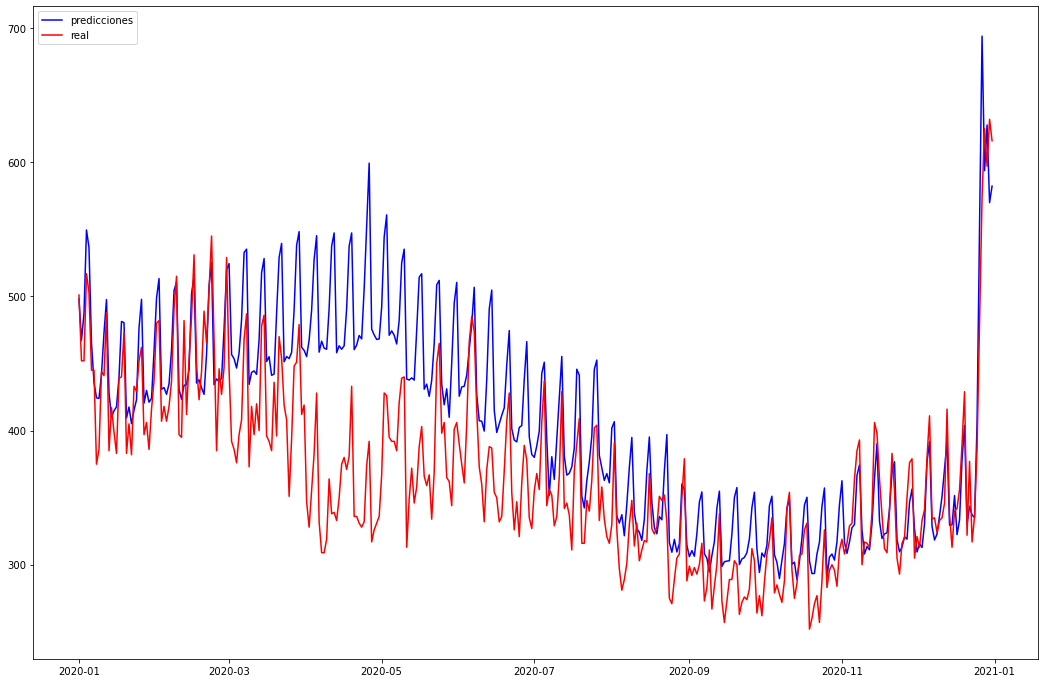

In [391]:
plt.figure(figsize=(18,12))
plt.plot(muestra.date, muestra.predictions, color='blue', label='predicciones')
plt.plot(muestra.date, muestra.num_sold, color='red', label='real')
plt.legend()
plt.show()

# Create submission

In [392]:
final_params = {
    'boosting_type': 'gbdt',
    'objective': 'mse',
    'metric': ['rmse', 'mape'],
#     'n_estimators':300,
#     'num_leaves': 31,
    'learning_rate': 0.03,
#      'feature_fraction': 0.8,
#      'bagging_fraction': 0.8,
#      'bagging_freq': 1,
    'verbose': -1,
    'n_estimators':70,
    
}

In [393]:
gbm_final = lgb.train(params,
                lgb_train_final)

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [394]:
submission = gbm_final.predict(X_test)

In [395]:
data = {'row_id': np.arange(70128,87648),
        'num_sold': submission
        }

In [396]:
final_submission = pd.DataFrame(data)

In [397]:
final_submission.to_csv('./data/final_submission.csv', index=False)